In [1]:
import os
%matplotlib widget
import scipy.constants as sc
from scipy.optimize import fsolve

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
import os
import h5py

print(os.getpid())
%cd ../../

import pylib.mix as mix
import pylib.measurement as mse

8272
/media/work/docs/codes/QuCF/scripts-py


In [2]:
# --- Launch to change cells' width ---
colors_ = ["blue", "red", "green", "gray", "black"]

from matplotlib import ticker
cmap_two_signs_= 'coolwarm'
cmap_two_signs_= 'Blues'
# cmap_two_signs_= 'Greys'
# cmap_two_signs_= 'Pastel1'
# cmap_two_signs_= 'flag'
# cmap_two_signs_= 'nipy_spectral'
# cmap_two_signs_= 'jet'
# cmap_two_signs_= 'seismic'
def fmt_(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

path_save_ = "./jupyter-notebooks/tests/results-hamiltonian/"

for i in range(10):
    plt.close()


*** Original Hamiltonian ***
--- 0 ---
 1.000+0.000j  2.000+0.000j
--- 1 ---
 2.000+0.000j  1.000+0.000j
sum y(t = t_max)**2: 1.000e+00

--- Initial state vector ---
 0.632+0.000j  0.775+0.000j 

Normalization factor: 4.472e+00

*** Normalized Hamiltonian ***
--- 0 ---
 0.224+0.000j  0.447+0.000j
--- 1 ---
 0.447+0.000j  0.224+0.000j

--- The angle for the initialization circuit ---
ay_init  1.772154247585e+00

--- The angles for the BE oracle ---
ay_H00  2.214297435588e+00
ay_H01  9.272952180016e-01
ay_H10  9.272952180016e-01
ay_H11  2.214297435588e+00


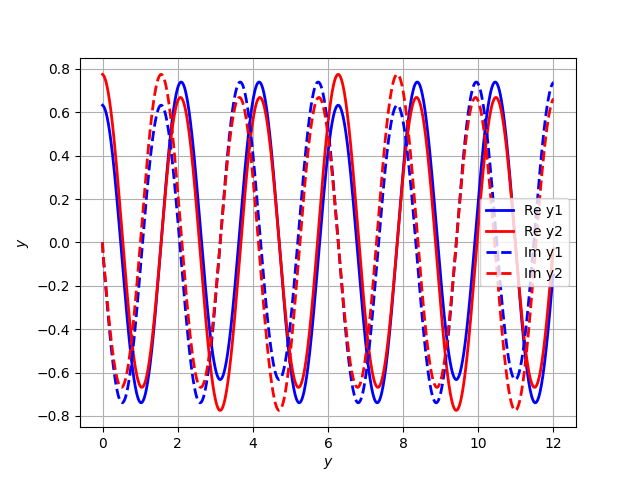

In [3]:
# -----------------------------------------------------------------
# SIMULATIONS: QuCF/QuCF/tests/qsvt-hamiltonian/hermitian/
# --- i d y1(t) / d t =    a1 * y1 - 1j*b * y2 ---
# --- i d y2(t) / d t =  1j*b * y1 +   a2 * y2 ---
# -----------------------------------------------------------------
from scipy.integrate import RK45
mix.reload_module(mix)

nt = 10
t_max = 12

# a1 = 0.1
# a2 = 0.4
# b  = 0.8

a1 = 1.
a2 = 1.
b  = 2.

Nt = 1 << nt
t = np.linspace(0, t_max, Nt)
dt = np.diff(t)[0]

# *** Form the Hamiltonian for the system ***
H_orig = np.ones((2, 2), dtype=complex)
H_orig[0,0] = a1
# H_orig[0,1] = 1-1j*b
# H_orig[1,0] = 1+1j*b
H_orig[0,1] = b
H_orig[1,0] = b
H_orig[1,1] = a2

print()
print("*** Original Hamiltonian ***")
mix.print_matrix(H_orig)

# simulated signals:
Ns = 2
y = np.zeros((Nt,Ns), dtype=complex)

# *** Set the initial signal ***
y[0,0] = np.sqrt(0.4)
y[0,1] = np.sqrt(0.6)

# ---------------------------------------------------------------------------------------------------
# --- Compute the time evolution ---
# ---------------------------------------------------------------------------------------------------
def calc_y(t,y):
    y = -1j*H_orig.dot(y) 
    return y

oo = RK45(
    calc_y,
    t[0], 
    y[0,:], t[-1], first_step=dt, max_step=dt
)

Nt_act = 0
oo.step() # skip one time step
while mix.compare_two_strings(oo.status, "running"):
    oo.step()
#     print(oo.t)
    Nt_act += 1
    y[Nt_act,:] = oo.y
print("sum y(t = t_max)**2: {:0.3e}".format(np.sum(np.abs(y[-1,:])**2)))


# ---------------------------------------------------------------------------------------------------
# --- Compute angles for initialization and block-encoding ---
# ---------------------------------------------------------------------------------------------------
print()
print("--- Initial state vector ---")
mix.print_array(y[0,:])

# *** Normalize the Hamiltonian ***
nonsparsity = 1 
if np.abs(b) > 0: 
    nonsparsity = 2
    
rows_sum = np.zeros(Ns)
for ir in range(Ns):
    rows_sum[ir] = np.sqrt(np.sum(np.abs(H_orig[ir,:])**2))
coef_norm_H = np.max(rows_sum)

final_norm_of_H_ = nonsparsity
if coef_norm_H > 1:
    final_norm_of_H_ *= coef_norm_H
    
H = H_orig/final_norm_of_H_

print("\nNormalization factor: {:0.3e}".format(final_norm_of_H_))

print()
print("*** Normalized Hamiltonian ***")
mix.print_matrix(H)

# *** Compute angles ***
ay_init = 2*np.arccos(y.real[0,0])  # Ry(ay_init_y1)*|0>

coef_OF = nonsparsity # take into account the action of the oracle OH
ay_H00, az_H00 = mix.calc_angles_from_a_value(H[0,0] * coef_OF)
ay_H01, az_H01 = mix.calc_angles_from_a_value(H[0,1] * coef_OF)
ay_H10, az_H10 = mix.calc_angles_from_a_value(H[1,0] * coef_OF)
ay_H11, az_H11 = mix.calc_angles_from_a_value(H[1,1] * coef_OF)


print()
print("--- The angle for the initialization circuit ---")
print("ay_init  {:0.12e}".format(ay_init))
    
print()
print("--- The angles for the BE oracle ---")
print("ay_H00  {:0.12e}".format(ay_H00))
if az_H00 is not None:
    print("az_H00  {:0.12e}".format(az_H00))
    
print("ay_H01  {:0.12e}".format(ay_H01))
if az_H01 is not None:
    print("az_H01  {:0.12e}".format(az_H01))
    
print("ay_H10  {:0.12e}".format(ay_H10))
if az_H10 is not None:
    print("az_H10  {:0.12e}".format(az_H10))
    
print("ay_H11  {:0.12e}".format(ay_H11))
if az_H11 is not None:
    print("az_H11  {:0.12e}".format(az_H11))


# ---------------------------------------------------------------------------------------------------
# --- Plot y1(t) and y2(t) ---
# ---------------------------------------------------------------------------------------------------
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t, y.real[:,0], "-b", linewidth = 2, label="Re y1")
ax.plot(t, y.real[:,1], "-r", linewidth = 2, label="Re y2")

ax.plot(t, y.imag[:,0], "--b", linewidth = 2, label="Im y1")
ax.plot(t, y.imag[:,1], "--r", linewidth = 2, label="Im y2")

# plt.xlim([0,2])

plt.xlabel('$y$')
plt.ylabel("$y$")
ax.legend()
plt.grid(True)
plt.show()

Reading the file ../QuCF/tests/qsp-hamiltonian/hermitian/hermitian_OUTPUT.hdf5...
Name of the simulation is hermitian
Simulation has been performed  07-05-2024 12:59:48
State-vector size: 2
Reading the file ../QuCF/tests/qsp-hamiltonian/hermitian/hermitian_ref_OUTPUT.hdf5...
Name of the simulation is hermitian
Simulation has been performed  11-23-2023 17:48:27
State-vector size: 2


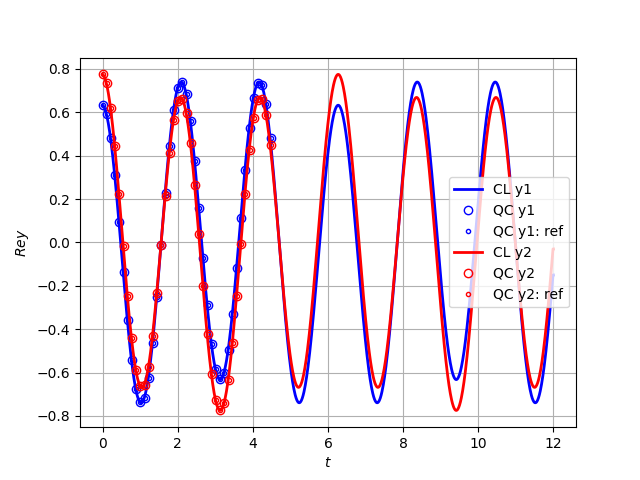

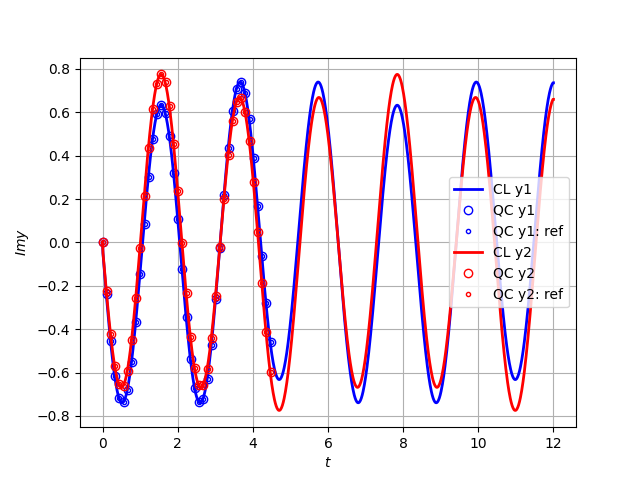

max. abs. err.: 2.987e-15


In [16]:
# -----------------------------------------------------------------
# SIMULATIONS: QuCF/QuCF/tests/qsvt-hamiltonian/hermitian/
# READ results from QSP simulations
# -----------------------------------------------------------------
mix.reload_module(mse)
def get_qucf(name_pr = "hermitian"):
    om = mse.MeasOracle__(True)
    om.path_ = "../QuCF/tests/qsp-hamiltonian/hermitian"
    om.pname_ = name_pr
    om.open()
    om.read_qsvt()
    qy = om.read_qsp_ham_results("hamiltonian", 0)
    qt = om.qsp_get_time_grid("hamiltonian", final_norm_of_H_)
    return qy, qt
# ---------------------------------------------------------------------------------------------------

qy_factor, qt = get_qucf()
qy_factor_ref, _ = get_qucf("hermitian_ref")

# --- REAL ---
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t,               y.real[:,0], "-b", linewidth = 2, label="CL y1")
ax.plot(qt,      qy_factor.real[:,0], "b", marker = 'o', markerfacecolor='None', linestyle='None', label="QC y1")
ax.plot(qt,  qy_factor_ref.real[:,0], "b", marker = '.', markerfacecolor='None', linestyle='None', label="QC y1: ref")

ax.plot(t,              y.real[:,1], "-r", linewidth = 2, label="CL y2")
ax.plot(qt,     qy_factor.real[:,1], "r", marker = 'o', markerfacecolor='None', linestyle='None', label="QC y2")
ax.plot(qt, qy_factor_ref.real[:,1], "r", marker = '.', markerfacecolor='None', linestyle='None', label="QC y2: ref")

plt.xlabel('$t$')
plt.ylabel("$Re y$")
ax.legend()
plt.grid(True)
plt.show()


# --- IMAG ---
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t,              y.imag[:,0], "-b", linewidth = 2, label="CL y1")
ax.plot(qt,     qy_factor.imag[:,0], "b", marker = 'o', markerfacecolor='None', linestyle='None', label="QC y1")
ax.plot(qt, qy_factor_ref.imag[:,0], "b", marker = '.', markerfacecolor='None', linestyle='None', label="QC y1: ref")

ax.plot(t,              y.imag[:,1], "-r", linewidth = 2, label="CL y2")
ax.plot(qt,     qy_factor.imag[:,1], "r", marker = 'o', markerfacecolor='None', linestyle='None', label="QC y2")
ax.plot(qt, qy_factor_ref.imag[:,1], "r", marker = '.', markerfacecolor='None', linestyle='None', label="QC y2: ref")

plt.xlabel('$t$')
plt.ylabel("$Im y$")
ax.legend()
plt.grid(True)
plt.show()

# --- Comparison ---
print(
    "max. abs. err.: {:0.3e}".format(
        np.max(np.abs(qy_factor_ref - qy_factor))
    )
)


In [25]:
# --- Success probability ---
prob = np.zeros(len(qy))
for ii in range(len(qy)):
    prob[ii] = np.sqrt(np.sum(np.abs(qy[ii,:])**2))
prob

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])